<a href="https://colab.research.google.com/github/abcardoso/ifes_ai/blob/main/FrameworkTSPAnaB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Framework TSP

In [3]:
# -*- coding: utf-8 -*-
"""Baseado no notebook IA-Hill_Climbing-TSP.ipynb do professor Sergio

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1Gnhhp0GX8140lAYv-uCg2qnR6E92gutX

# HILL CLIMBING e SIMULATED ANNEALING - TSP

Aplicação dos algoritmos Hill Climbing e Simulated Annealing para solucionar o problema do caixeiro viajante (TSP)

## Importações
"""

# Manipulação de dados
import numpy as np
import pandas as pd
import math

# Geração de números aleatórios
import random

# Geração de gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import clear_output

# Funções Auxiliares

# Cria uma solucao inicial com as cidades em um ordem aleatoria
# Funções auxiliares e de geração de soluções
# Funções auxiliares e de geração de soluções
def solucao_aleatoria(tsp):
    cidades = list(tsp.keys())
    solucao = []

    cidade = cidades[0]
    solucao.append(cidade)
    cidades.remove(cidade)

    for _ in range(0,len(cidades)):
        cidade = random.choice(cidades)
        solucao.append(cidade)
        cidades.remove(cidade)

    return solucao

def calcula_custo(tsp, solucao):
    N = len(solucao)
    custo = 0

    for i in range(N):
        k = (i+1) % N
        cidadeA = solucao[i]
        cidadeB = solucao[k]
        custo += tsp.loc[cidadeA, cidadeB]

    return custo

def gera_vizinhos(solucao):
    N = len(solucao)
    for i in range(1, N):       # deixa o primeiro fixo
        for j in range(i + 1, N):
            vizinho = solucao.copy()
            vizinho[i] = solucao[j]
            vizinho[j] = solucao[i]
            yield(vizinho)

def obtem_melhor_vizinho(tsp, solucao):
    melhor_custo = calcula_custo(tsp, solucao)
    melhor_vizinho = solucao

    for vizinho in gera_vizinhos(solucao):
        custo_atual = calcula_custo(tsp, vizinho)
        if custo_atual < melhor_custo:
            melhor_custo = custo_atual
            melhor_vizinho = vizinho

    return melhor_vizinho, melhor_custo

def obtem_vizinho_aleatorio(tsp, solucao):
    vizinhos = list(gera_vizinhos(solucao))
    aleatorio_vizinho  = random.choice(vizinhos)
    aleatorio_custo    = calcula_custo(tsp, aleatorio_vizinho)
    return aleatorio_vizinho, aleatorio_custo

# Cálculo da Matriz de Distâncias
def distancia(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return np.sqrt(dx ** 2 + dy ** 2)

def gera_matriz_distancias(Coordenadas):
    n_cidades = len(Coordenadas)
    dist = np.zeros((n_cidades, n_cidades), dtype=float)
    for i in range(n_cidades):
        for j in range(i + 1, n_cidades):
            x1, y1 = Coordenadas.iloc[i]
            x2, y2 = Coordenadas.iloc[j]
            dist[i, j] = distancia(x1, y1, x2, y2)
            dist[j, i] = dist[i, j]
    return dist

# Gera aleatoriamente as coordenadas de N cidades.
def gera_coordenadas_aleatorias(n_cidades):
    minimo = 10
    maximo = 90
    escala = (maximo - minimo) - 1
    X = minimo + escala * np.random.rand(n_cidades)
    Y = minimo + escala * np.random.rand(n_cidades)
    coordenadas = {'X': X, 'Y': Y}
    cidades = ['A' + str(i) for i in range(n_cidades)]
    df_cidades = pd.DataFrame(coordenadas, index=cidades)
    df_cidades.index.name = 'CIDADE'
    return df_cidades

# Recebe uma lista com as coordenadas reais de uma cidade e gera uma matriz de distancias entre as cidades.
def gera_problema_tsp(df_cidades):
    cidades = df_cidades.index
    distancias = gera_matriz_distancias(df_cidades)
    tsp = pd.DataFrame(distancias, columns=cidades, index=cidades)
    return tsp

Hill Climbing

In [4]:
#Random Walk e Hill Climbing
def random_walk(tsp):
    solucao_inicial = solucao_aleatoria(tsp)
    atual_solucao, atual_custo = obtem_vizinho_aleatorio(tsp, solucao_inicial)
    for _ in range(30):
        atual_solucao, atual_custo = obtem_vizinho_aleatorio(tsp, atual_solucao)
    return atual_custo, atual_solucao

def hill_climbing(tsp):
    solucao_inicial = solucao_aleatoria(tsp)
    solucao_melhor, custo_melhor = obtem_melhor_vizinho(tsp, solucao_inicial)
    while True:
        candidato_novo, custo_novo = obtem_melhor_vizinho(tsp, solucao_melhor)
        if custo_novo < custo_melhor:
            custo_melhor   = custo_novo
            solucao_melhor = candidato_novo
        else:
            break
    return custo_melhor, solucao_melhor

def hill_climbing_restart(tsp):
    for _ in range(50):
        solucao_inicial = solucao_aleatoria(tsp)
        solucao_melhor, custo_melhor = obtem_melhor_vizinho(tsp, solucao_inicial)
        while True:
            candidato_atual, custo_atual = obtem_melhor_vizinho(tsp, solucao_melhor)
            if custo_atual < custo_melhor:
                custo_melhor   = custo_atual
                solucao_melhor = candidato_atual
            else:
                break
    return custo_melhor, solucao_melhor

Plot

In [5]:

# Funções de Plotagem
def plota_rotas(df_cidades, ordem_cidades):
    df_solucao = df_cidades.copy()
    df_solucao = df_solucao.reindex(ordem_cidades)

    X = df_solucao['X']
    Y = df_solucao['Y']
    cidades = list(df_solucao.index)

    fig = go.Figure()
    fig.update_layout(autosize=False, width=500, height=500, showlegend=False)
    fig.add_trace(go.Scatter(x=X, y=Y, text=cidades, textposition='bottom center', mode='lines+markers+text', name=''))
    fig.add_trace(go.Scatter(x=X.iloc[[-1,0]], y=Y.iloc[[-1,0]], mode='lines+markers', name=''))
    fig.show()

def boxplot_sorted(df, rot=90, figsize=(12,6), fontsize=20):
    df2 = df.T
    meds = df2.median().sort_values(ascending=False)
    axes = df2[meds.index].boxplot(figsize=figsize, rot=rot, fontsize=fontsize,
                                   boxprops=dict(linewidth=4, color='cornflowerblue'),
                                   whiskerprops=dict(linewidth=4, color='cornflowerblue'),
                                   medianprops=dict(linewidth=4, color='firebrick'),
                                   capprops=dict(linewidth=4, color='cornflowerblue'),
                                   flierprops=dict(marker='o', markerfacecolor='dimgray',
                                        markersize=12, markeredgecolor='black'),
                                   return_type="axes")

    axes.set_title("Cost of Algorithms", fontsize=fontsize)

def plot_path(cities_xy, cities_path, ax):
    city_indices = [cities_xy.index.get_loc(city) for city in cities_path]
    cities = cities_xy.values[city_indices]
    x = cities[:, 0]
    y = cities[:, 1]
    ax.set_xlabel('X (Longitude)')
    ax.set_ylabel('Y (Latitude)')
    ax.set_title('Caminho')
    ax.plot(x, y, color='blue', linestyle='-', linewidth=2)
    ax.plot(x, y, color='red', marker='o', markersize=8, linestyle='')
    ax.plot(x[[-1, 0]], y[[-1, 0]], color='orange', linestyle='-', linewidth=2)

def plot_distances(iteration_list, distance_list, best_distances, ax):
    x  = iteration_list
    y1 = distance_list
    y2 = best_distances

    ax.set_xlabel('Iterações')
    ax.set_ylabel('Distâncias (custos)')
    ax.set_title('Comprimento Total do caminho')

    ax.plot(x,y1, label='Atual')
    ax.plot(x,y2, label='Melhor')
    ax.legend()

def plot_acceptance_prob(iteration_list, accept_p_list, ax):
    x = iteration_list
    y = accept_p_list

    ax.set_xlabel('Iterações')
    ax.set_ylabel('Probabilidade')
    ax.set_title('Probabilidade de Aceitação')

    ax.set_ylim([0, 1.05])

    xc, yc, colors = zip(*[(xi, yi, 'b') if yi==1.0 else (xi, yi, 'r') for xi, yi in enumerate(y)])

    ax.scatter(xc, yc, c=colors, s=2)

def plot_temperature(iteration_list, temperat_list, ax):
    x = iteration_list
    y = temperat_list

    ax.set_xlabel('Iterações')
    ax.set_ylabel('Temperatura')
    ax.set_title('Decaimento da Temperatura')

    ax.set_ylim([0, 1000])

    ax.plot(x,y)

def plot_axes_figure(cities_xy, cities_path, iteration_list, distance_list, best_distances, accept_p_list, temperat_list):
    x = iteration_list
    y1 = distance_list
    y2 = best_distances
    y3 = accept_p_list
    y4 = temperat_list
    clear_output(wait=True)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))
    plot_path(cities_xy, cities_path, ax1)
    plot_distances(x, y1, y2, ax2)
    plot_acceptance_prob(x, y3, ax3)
    plot_temperature(x, y4, ax4)
    fig.tight_layout()
    plt.pause(0.001)


SA

In [6]:
# Funções de SA
def acceptance_probability(current_fitness, new_fitness, temperature):
    if new_fitness > current_fitness:
        return 1.0
    else:
        return math.exp((current_fitness - new_fitness) / temperature)

def simulated_annealing(tsp, df_cidades, initial_temperature, cooling_rate, iterations, nrep=50):
    num_cities = len(df_cidades)
    distance_matrix = tsp.values

    current_solution = solucao_aleatoria(tsp)
    current_fitness = -calcula_custo(tsp, current_solution)

    best_solution = current_solution
    best_fitness = current_fitness

    temperature = initial_temperature

    iteration_list = []
    best_distances = []
    distance_list  = []
    accept_p_list  = []
    temperat_list  = []

    for iteration in range(iterations):
        for _ in range(nrep):
            new_solution = random.choice(list(gera_vizinhos(current_solution)))
            new_fitness = -calcula_custo(tsp, new_solution)

            acceptance_prob = acceptance_probability(current_fitness, new_fitness, temperature)
            if random.random() < acceptance_prob:
                current_solution = new_solution
                current_fitness = new_fitness

        temperature *= cooling_rate

        if -new_fitness < -best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness

        iteration_list += [iteration]
        best_distances += [-best_fitness]
        distance_list  += [-current_fitness]
        accept_p_list  += [acceptance_prob]
        temperat_list  += [temperature]

        if iteration % 50 == 0:
            plot_axes_figure(df_cidades, current_solution, iteration_list, distance_list, best_distances, accept_p_list, temperat_list)

    return -best_fitness, best_solution


Execução

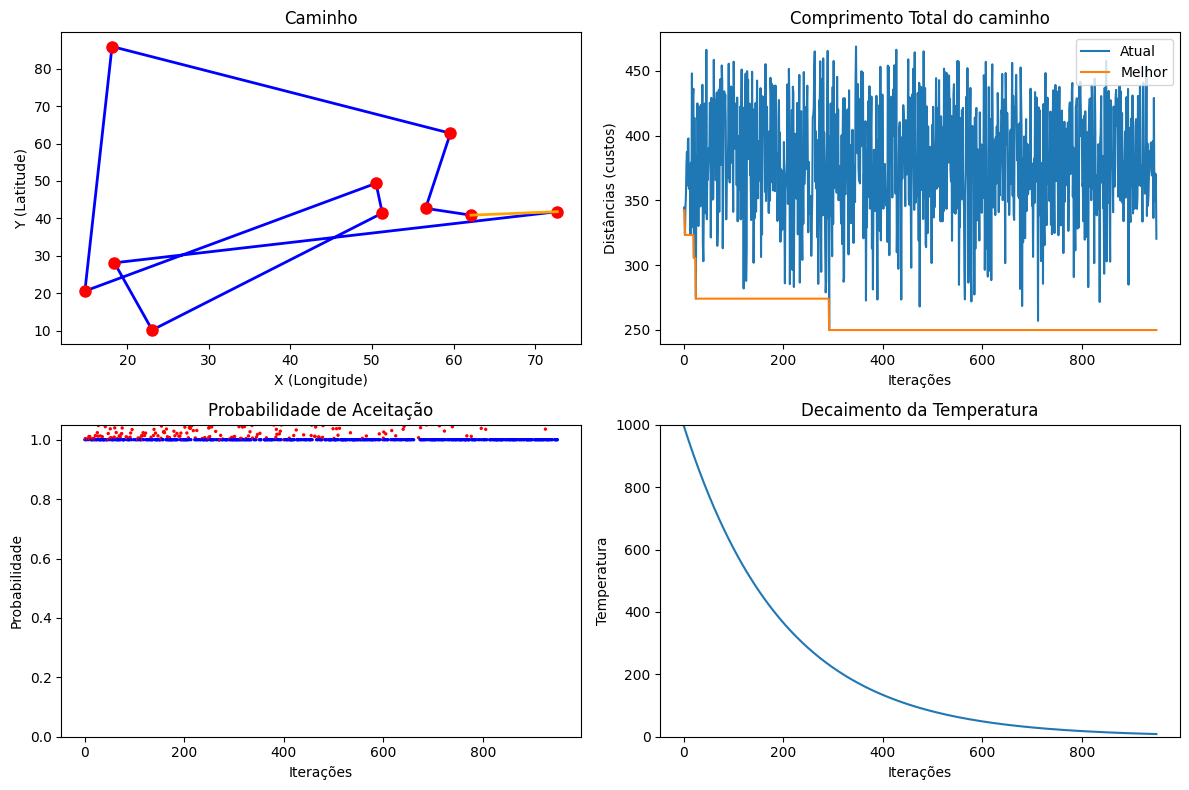

   249.765  ['A0', 'A2', 'A9', 'A1', 'A7', 'A4', 'A6', 'A3', 'A5', 'A8']


ALGORITMO,Random Walk,Hill Climbing,Simulated Annealing
count,30.000000,30.000000,30.000000
mean,385.650639,237.564332,246.741943
std,50.783309,11.241436,5.634254
min,274.322287,227.390687,235.600305
25%,353.223477,232.008436,243.364128
50%,391.979748,232.169019,246.725096
75%,421.079014,232.949842,249.561440
max,461.744198,262.794316,257.413590


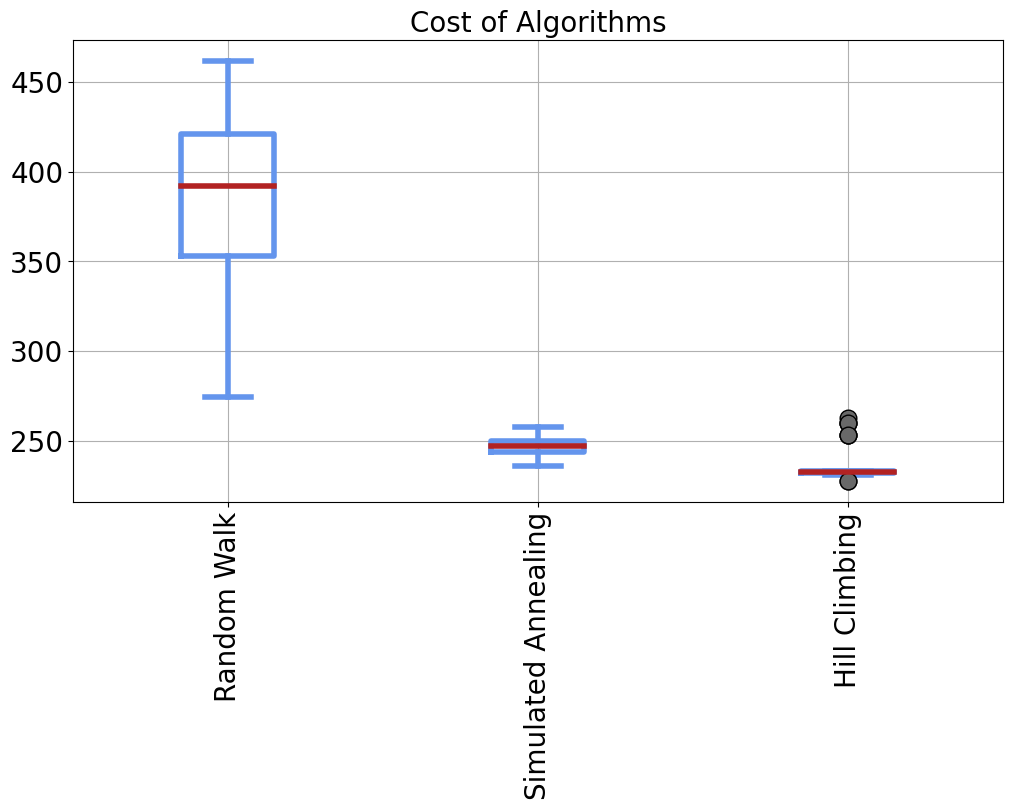

In [7]:
# Execução dos algoritmos

# Simula a criação de N cidades com suas respectivas distâncias
n_cidades = 10
df_coordenadas = gera_coordenadas_aleatorias(n_cidades)
tsp = gera_problema_tsp(df_coordenadas)

# Hill Climbing
custo_hc, solucao_hc = hill_climbing(tsp)
print(f'Hill Climbing: Custo: {custo_hc:.3f}, Solução: {solucao_hc}')
plota_rotas(df_coordenadas, solucao_hc)

# Simulated Annealing
initial_temperature = 1000.0
cooling_rate = 0.995
iterations = 1000
custo_sa, solucao_sa = simulated_annealing(tsp, df_coordenadas, initial_temperature, cooling_rate, iterations)
print(f'Simulated Annealing: Custo: {custo_sa:.3f}, Solução: {solucao_sa}')
plota_rotas(df_coordenadas, solucao_sa)

# Executa N vezes para gerar estatísticas da variável custo
def cria_df_custos(algoritmos, n_vezes):
    nomes_algoritmos  = algoritmos.keys()
    n_lin = len(nomes_algoritmos)
    n_col = n_vezes
    df_results = pd.DataFrame(np.zeros((n_lin, n_col)), index=nomes_algoritmos)
    df_results.index.name='ALGORITMO'
    return df_results

def executa_n_vezes(tsp, algoritmos, n_vezes):
    df_custo = cria_df_custos(algoritmos, n_vezes)
    for algoritmo, funcao_algoritmo in algoritmos.items():
        print(algoritmo)
        for i in range(n_vezes):
            custo, solucao = funcao_algoritmo(tsp)
            df_custo.loc[algoritmo,i] = custo
            print(f'{custo:10.3f}  {solucao}')
    return df_custo

algoritmos = {
    'Random Walk': random_walk,
    'Hill Climbing': hill_climbing,
    'Simulated Annealing': lambda tsp: simulated_annealing(tsp, df_coordenadas, initial_temperature, cooling_rate, iterations)
}

tsp = gera_problema_tsp(df_coordenadas)
n_vezes = 30
df_custo = executa_n_vezes(tsp, algoritmos, n_vezes)
boxplot_sorted(df_custo, rot=90, figsize=(12,6), fontsize=20)
df_custo.T.describe()